# Problem Set 2: Softmax Regression for NMNIST Digit Recognization
### Richard Chen
### EN.600.475.01

In [11]:
from utils import save_submission,load_data
import numpy as np
import copy
import math
import matplotlib.pylab as plt
%matplotlib inline
CLASSES = 10 # note: could have inferred this automatically from the labels

In [12]:
def softmax(Z):
    """
    Convert a set of scores from a linear model into a softmax posterior
    Input:
    Z: N x C array of scores
        Z[n][:] is the set of scores for C classes for the n-th example
    Output:
    S: N x C array
        S[n][:] is the softmax distribution over C classes for the n-th example
    """
    softmax_eq = lambda x: np.divide(np.array([math.e**(i-max(x)) for i in x]), sum([math.e**(j-max(x)) for j in x]))
    
    S = np.zeros(np.shape(Z))
    for i in range(S.shape[0]):
        S[i,:] = softmax_eq(Z[i,:])
    return S

def predict(X, model):
    """
    Evaluate the soft predictions of the model.
    Input:
    X : N x d array (no unit terms)
    model : dictionary containing 'weight' and 'bias'
    Output:
    yhat : N x C array
        yhat[n][:] contains the softmax posterior distribution over C classes for X[n][:]
    """
    return softmax(np.dot(X, model['weight']) + model['bias'])

def test(X, Y, model):
    """
    Compute hard label assignments based on model predictions, and return the accuracy vector
    Input:
    X : N x d array of data (no constant term)
    Y : N x C array with 1-hot encoding of true labels
    model: dictionary 
    Output:
    acc : N array of errors, acc[n] is 1 if correct and 0 otherwise
    """
    return predict(X, model).argmax(-1) == Y.argmax(-1)

def error_rate(X, Y, model):
    """
    Compute error rate (between 0 and 1) for the model
    """
    return 1 - test(X, Y, model).mean()

def calc_loss(X, Y, model):
    """
    Evaluate the loss (without regularization penalty), i.e., normalized negative log likelihood
    """
    Z = predict(X, model)
    return -(Y * np.log(Z)).sum() / len(Y)

In [13]:
def calcGrad(X, Y, model):
    """
    Calculate the gradient of the loss w.r.t. model parameters
    Output:
    grad_W : same dimension as model['weight']; gradient w.r.t. the weights
    grad_b : same dimension as model['bias']; gradient w.r.t. the bias terms
    """
    
    Y_hat = predict(X, model)
    grad_W = np.transpose(np.dot(np.transpose(Y_hat-Y), X)) # 576 x 10, same as W
    grad_b = np.transpose(np.sum(Y_hat-Y, axis = 0)) # 10 by 10

    return grad_W, grad_b

def modelUpdate(X, Y, model, lambda_, eta):
    """
    Update the model
    Input:
    X, Y : the inputs and 1-hot encoded labels
    model : the currrent model
    lambda : regularization coefficient for L2 penalty
    eta : learning rate
    Output:
    updated model
    """
    
    grad_W,grad_b = calcGrad(X,Y,model)
    model['weight'] = model['weight'] - eta*(grad_W + 2.0*lambda_*model['weight'])
    model['bias'] = model['bias'] - eta*(grad_b)
    return model

In [14]:
def runTrainVal(X,Y,model,Xval,Yval,trainopt):
    """
    Run the train + evaluation on a given train/val partition
    trainopt: various (hyper)parameters of the training procedure
    """
    
    eta = trainopt['eta']
    
    N = X.shape[0] # number of data points in X
    
    shuffled_idx = np.random.permutation(N)
    start_idx = 0
    for iteration in range(trainopt['maxiter']):
        if iteration % int(trainopt['eta_frac'] * trainopt['maxiter']) == 0:
            eta *= trainopt['etadrop']
        # form the next mini-batch
        stop_idx = min(start_idx + trainopt['batch_size'], N)
        batch_idx = range(N)[int(start_idx):int(stop_idx)]
        bX = X[shuffled_idx[batch_idx],:]
        bY = Y[shuffled_idx[batch_idx],:]
        if (iteration % trainopt['display_iter']) == 0:
            print('{:8} batch loss: {:.3f}'.format(iteration, calc_loss(bX, bY, model)))
        model = modelUpdate(bX, bY, model, trainopt['lambda'], eta)
        start_idx = stop_idx % N
        
    # compute train and val error; multiply by 100 for readability (make it percentage points)
    trainError = 100 * error_rate(X, Y, model)
    valError = 100 * error_rate(Xval, Yval, model)
    
    return model,valError,trainError

In [5]:
data_fn = "nmnist.h5"

print("Load small train.")
Xsmall,Ysmall = load_data(data_fn, "small_train")
print(Xsmall.shape)
print(Ysmall.shape)

print("Load large train.")
Xlarge,Ylarge = load_data(data_fn, "large_train")
print(Xlarge.shape)
print(Ylarge.shape)

print("Load val.")
Xval,Yval = load_data(data_fn, "val")
print(Xval.shape)
print(Yval.shape)

Load small train.
(400, 576)
(400, 10)
Load large train.
(7000, 576)
(7000, 10)
Load val.
(2000, 576)
(2000, 10)


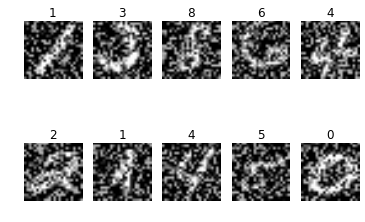

In [6]:
# -- display first ten small train examples
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(Xsmall[i,:].reshape(24,24),cmap='gray')
    plt.title(repr(Ysmall[i].argmax(-1)))
    plt.axis('off')

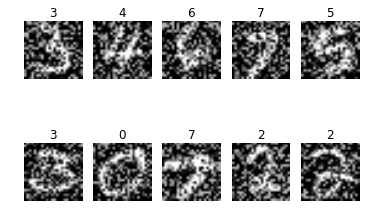

In [7]:
# -- display first ten val examples
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(Xval[i,:].reshape(24,24),cmap='gray')
    plt.title(repr(Yval[i].argmax(-1)))
    plt.axis('off')

In [17]:
# -- training options; these are suggestions, feel free to experiment
trainopt = {
    'eta': 0.5,   # initial learning rate
    'maxiter': 100000,   # max number of iterations (updates) of SGD
    'display_iter': 10000,  # display batch loss every display_iter updates
    'batch_size': 10,  
    'etadrop': .5, # when dropping eta, multiply it by this number (e.g., .5 means halve it)
    'eta_frac': .2  # drop eta every eta_frac fraction of the max iterations
                    # so if eta_frac is .2, and maxiter is 10000, drop eta every 2000 iterations
}

NFEATURES = Xsmall.shape[1]

seed = np.random.RandomState(2341)  # to make sure everyone starts from the same point
random_init = seed.normal(scale=0.01, size=(NFEATURES,CLASSES)) # -- with random seed fixed

model = { 'weight': random_init, 'bias': np.zeros(CLASSES) }

# set the (initial?) set of lambda values to explore
lambdas = np.arange(0,0.1,0.005)


# we will maintain a record of models trained for different values of lambda
# these will be indexed directly by lambda value itself
small_trained_models = dict()
large_trained_models = dict()

# -- small train set: sweep the lambda values
for lambda_ in lambdas:
    trainopt['lambda'] = lambda_
    # -- model trained on small train set
    # note: you need deepcopy here because of the way Python handles copying of complex objects like dictionaries
    # by default, it would copy it by reference, i.e., it would make a new pointer to the same data, so later changing
    # the contents would change the "copied" version as well. deepcopy actually makes a copy.
    trained_model,valErr,trainErr = runTrainVal(Xsmall, Ysmall, copy.deepcopy(model), Xval, Yval, trainopt)
    small_trained_models[lambda_] = {'model': trained_model, "val_err": valErr, "train_err": trainErr }
    print('small train set model: -> lambda= %.4f, train error: %.2f, val error: %.2f' % (lambda_, trainErr, valErr))
    print
    
for lambda_ in lambdas:
    trainopt['lambda'] = lambda_
    # -- model trained on large train set
    trained_model,valErr,trainErr = runTrainVal(Xlarge, Ylarge, copy.deepcopy(model), Xval, Yval, trainopt)
    large_trained_models[lambda_] = {'model': trained_model, "val_err": valErr, "train_err": trainErr }
    print('large train set model: -> lambda= %.4f, train error: %.2f, val error: %.2f' % (lambda_, trainErr, valErr))
    print
    
best_small_trained_lambda = 0.
best_small_trained_model = None
best_small_trained_val_err = 100.
for lambda_,results in small_trained_models.items():
    if results['val_err'] < best_small_trained_val_err:
        best_small_trained_val_err = results['val_err']
        best_small_trained_model = results['model']
        best_small_trained_lambda = lambda_
        
best_large_trained_lambda = 0.
best_large_trained_model = None
best_large_trained_val_err = 100.
for lambda_,results in large_trained_models.items():
    if results['val_err'] < best_large_trained_val_err:
        best_large_trained_val_err = results['val_err']
        best_large_trained_model = results['model']
        best_large_trained_lambda = lambda_

print("Best small train model val err:", best_small_trained_val_err)
print("Best small train model lambda:", best_small_trained_lambda)
print("Best large train model val err:", best_large_trained_val_err)
print("Best large train model lambda:", best_large_trained_lambda)

       0 batch loss: 2.281
   10000 batch loss: 0.000
   20000 batch loss: 0.000
   30000 batch loss: 0.000
   40000 batch loss: 0.000
   50000 batch loss: 0.000
   60000 batch loss: 0.000
   70000 batch loss: 0.000
   80000 batch loss: 0.000
   90000 batch loss: 0.000
small train set model: -> lambda= 0.0000, train error: 0.00, val error: 32.55

       0 batch loss: 2.314
   10000 batch loss: 0.025
   20000 batch loss: 0.025
   30000 batch loss: 0.024
   40000 batch loss: 0.024
   50000 batch loss: 0.023
   60000 batch loss: 0.023
   70000 batch loss: 0.023
   80000 batch loss: 0.023
   90000 batch loss: 0.023
small train set model: -> lambda= 0.0050, train error: 0.00, val error: 31.00

       0 batch loss: 2.335
   10000 batch loss: 0.336
   20000 batch loss: 0.000
   30000 batch loss: 0.048
   40000 batch loss: 0.047
   50000 batch loss: 0.044
   60000 batch loss: 0.044
   70000 batch loss: 0.043
   80000 batch loss: 0.043
   90000 batch loss: 0.043
small train set model: -> lambda

In [18]:
#Generate a Kaggle submission file using `model`

#for model trained on small_train
kaggleX = load_data(data_fn, 'kaggle')
kaggleYhat_small = predict(kaggleX, best_small_trained_model).argmax(-1)
save_submission('submission-small.csv', kaggleYhat_small)

#for model trained on large_train
kaggleYhat_large = predict(kaggleX, best_large_trained_model).argmax(-1)
save_submission('submission-large.csv', kaggleYhat_large)

('Saved:', 'submission-small.csv')
('Saved:', 'submission-large.csv')


# Report

### 1. Kaggle Results

Under the username "richarizardd" (rchen40@jhu.edu), my score for:
* cs475-nmnist-small is 0.73
* cs475-nmnist-large is 0.816

### 2. Statistics

In [60]:
def print_statistics(X, Y, model):
    """
    Method I wrote to evaluate our model.
    X: Validation Set of X
    Y: Validation Set of Y
    """
    
    # Confusion Matrix Statistics
    Y_hat_predict, Y_predict = predict(X, model).argmax(-1), Y.argmax(-1)
    CM = np.zeros((Y.shape[1], Y.shape[1]))
    for i in range(len(Y_hat_predict)):
        CM[Y_predict[i]][Y_hat_predict[i]] += 1

    # Validation Error
    valError = 100 * error_rate(X, Y, model)
    
    # Print Results
    print "Validation Error:", valError
    print "Confusion Matrix"
    print CM

print "Statistics for Best Small Train Model:"
print_statistics(Xval, Yval, best_small_trained_model)
print
print "Statistics for Best Large Train Model:"
print_statistics(Xval, Yval, best_large_trained_model)

Statistics for Best Small Train Model:
Validation Error: 30.95
Confusion Matrix
[[ 154.    0.    3.    2.    1.    5.   14.    3.    3.    2.]
 [   0.  213.    1.    0.    2.    0.    0.    1.    4.    2.]
 [   3.   22.  130.    6.    7.    3.    4.   10.   20.    5.]
 [   6.   15.   13.   99.    0.   18.    0.    4.   17.   11.]
 [   0.    3.    3.    0.  136.    6.    1.   15.    1.   28.]
 [   8.   13.    6.   19.   13.   76.    8.    5.    9.   15.]
 [   2.   10.   10.    0.    9.   10.  167.    3.    3.    3.]
 [   4.   14.    1.    0.    4.    0.    1.  178.    2.   29.]
 [   3.   17.    8.    8.    7.   11.    0.    2.  117.   23.]
 [   1.    8.    3.    3.   24.    2.    4.   26.    4.  111.]]

Statistics for Best Large Train Model:
Validation Error: 19.5
Confusion Matrix
[[ 169.    0.    3.    1.    0.    5.    3.    3.    1.    2.]
 [   0.  190.    7.    2.    2.    5.    1.    6.   10.    0.]
 [   3.    2.  170.    5.    4.    4.    2.    8.    7.    5.]
 [   0.    1.   17. 

### 2. Visualization and Interpretation

Visualization of the learned parameters for the best small trained model:


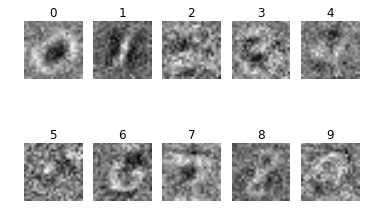

In [68]:
print "Visualization of the learned parameters for the best small trained model:"
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(best_small_trained_model['weight'][:,i].reshape(24,24),cmap='gray')
    plt.title(repr(i))
    plt.axis('off')

Visualization of the learned parameters for the best large trained model:


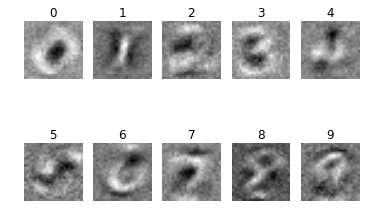

In [69]:
print "Visualization of the learned parameters for the best large trained model:"
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(best_large_trained_model['weight'][:,i].reshape(24,24),cmap='gray')
    plt.title(repr(i))
    plt.axis('off')

Every nmnist data point (image) can be thought of as an array of numbers describing how light each pixel is. In order to recognize and clasify these images, by flattening the image into a $1 \times 576$ image, our model is essentially trying to learn parameters $w_c$ in $W$ on pixel locations where that image is light, where the dark regions shade the digit we are trying to recognize. As a result, for an image that contains a number "1", our weight vector $w_1$ will be weighted in pixel locations where it is essentially a line down the center. Likewise, for a number like "0", we would expect a patch of dark pixels in the center, with a ring of white pixels surrounding this patch. These indices in $w_c$ are positive as they act as receptive fields that "activate" when it sees its own image, so if restack this array back into a $24 \times 24$ shape, we should see the original image, as these are the pixel locations/indices that are weighted favorably for each and every $w_c$. Though originally unclear as to why our softmax classifier "confused" the digit "0" and "7", from the visualization, we see that $w_7$ is weighted such that it has a dark patch in the middle, with a white curve around this patch that debatably looks like a "7".

The reason why we would regularize out model (as opposed to leaving it unregularized) is because we are treating every pixel in our image as a feature in our softmax model. In actually trying to recognize a digit, not all of the features are necessary in trying to perform digit recognization, as not all of the pixels are part of the class-of-interest. As a result, we use regularization to penalize parameters that are not important for that class. As a result, we are using regularization to reduce model complexity, and in term, prevent over-fitting in our data. Between the small dataset and the large dataset, because the large dataset has more images, our large model has more model complexity and is prone to overfitting.A s a result, we see that we need a bigger regularization parameter (0.075 as opposed to 0.01) in order to help our larger model generalize to new images.